In [ ]:
import pandas as pd
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path=f"/content/drive/MyDrive/books_to_kindle_and_books_parquets/books/1_book_after_preprocessing.parquet"

In [ ]:
df = pl.read_parquet(file_path)
df_pandas = df.to_pandas()

We take only those who are had reviewed at least 50 reviews and no more than 100. On one hand, we do not want users that reviewed 3000 books, with the same review, because this are not legitimic users. On the other hand, we understood that the way recommendation system works is based on data that the user voted, and this is the minimun to make the recommendation system work. Also, some models collapsed while we had other filters such as 10 to 100, and this is just the first file.
 At first we just want to build few pytorch-based recommendation models, and then, once deciding which model we would use, based on its preformance, we will expand the training input, to be not more than just the first file (we have 14 in the drive, making it able to read the whole data in parts).

In [ ]:
user_counts = df_pandas['reviewerID'].value_counts()
users_with_50_100_reviews = user_counts[(user_counts >= 50) & (user_counts <= 100)]
num_users_50_100_reviews = len(users_with_50_100_reviews)
print(f"Number of users with 50 -100 records: {num_users_50_100_reviews}")



Number of users with 50 -100 records: 1869


In [ ]:
filtered_users = users_with_50_100_reviews.index.tolist()
df_filtered = df_pandas[df_pandas['reviewerID'].isin(filtered_users)]
print("Filtered DataFrame:")
print(df_filtered)

Filtered DataFrame:
         overall  verified      reviewerID        asin  \
15             5     False  A3H9YD6K9TVKDP  0001713353   
47             5     False  A3QYDL5CDNYN66  0001061240   
72             5     False  A1BNWEJ7RVPLQ1  0001712799   
98             4     False  A3CKPNSGA7JOLK  0001712799   
106            5     False  A2MOBMVHECYVLE  0002006448   
...          ...       ...             ...         ...   
3688416        5     False  A1NSJ7IFI4IZ4Q  0316403490   
3688435        5     False  A25OO2VLCIWV51  0316403490   
3688471        5     False  A2GGSOEKD5VCPK  0316403784   
3688480        1      True  A1MD99Z7WM27LS  0316403784   
3688493        4      True  A2CISZ4JLKQRJA  0316403784   

                             style  \
15       {'Format:': ' Hardcover'}   
47       {'Format:': ' Hardcover'}   
72       {'Format:': ' Hardcover'}   
98       {'Format:': ' Hardcover'}   
106      {'Format:': ' Hardcover'}   
...                            ...   
3688416  {'Format

In [ ]:
del df_pandas, df
import gc
gc.collect()

0

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import json
from sklearn.metrics import ndcg_score

We start with the most simple model and then step by step improve it:

In [ ]:

train_df, test_df = train_test_split(df_filtered, test_size=0.2)

# Create dictionaries to map user and book IDs to integers
user_to_idx = {user_id: i for i, user_id in enumerate(df_filtered['reviewerID'].unique())}
book_to_idx = {asin: i for i, asin in enumerate(df_filtered['asin'].unique())}

# Convert user and book IDs to integers in the DataFrame
train_df['user_idx'] = train_df['reviewerID'].map(user_to_idx)
train_df['book_idx'] = train_df['asin'].map(book_to_idx)
test_df['user_idx'] = test_df['reviewerID'].map(user_to_idx)
test_df['book_idx'] = test_df['asin'].map(book_to_idx)


# First model: simple user/books embedding
The embedding is the part that creates random values which represent the similarity between users and books (with length of n_user or n_books multiplied by n_factors). It could have been achieved also with nn.Parameter(user_factors), and then creating the random values with randn, however, it seems more common in recommendation system to use the embedding in the creation of the model.

In [ ]:
class CFModel(nn.Module):
    def __init__(self, df_filtered, n_factors=5):
        super(CFModel, self).__init__()
        n_users = df_filtered['reviewerID'].nunique()
        n_books = df_filtered['asin'].nunique()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.books_factors = nn.Embedding(n_books, n_factors)

    def forward(self, user_idx, book_idx):
        user_embed = self.user_factors(user_idx)
        book_embed = self.books_factors(book_idx)
        pred_rating = (user_embed * book_embed).sum(dim=1)
        return pred_rating



We are storing the models with pickle using built-in pytorch saving syntax, after the training process

In [ ]:


user_idx_tensor = torch.LongTensor(train_df['user_idx'].values).to(device)
book_idx_tensor = torch.LongTensor(train_df['book_idx'].values).to(device)
ratings_tensor = torch.FloatTensor(train_df['overall'].values).to(device)
train_dataset = TensorDataset(user_idx_tensor, book_idx_tensor, ratings_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
model = CFModel(df_filtered).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for user_idx, book_idx, ratings in train_loader:
        optimizer.zero_grad()
        pred_ratings = model(user_idx, book_idx)
        loss = criterion(pred_ratings, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

torch.save(model.state_dict(), '/content/drive/MyDrive/models/first_cf_model.pth')




Epoch 1/20, Average Loss: 22.1751
Epoch 2/20, Average Loss: 19.4319
Epoch 3/20, Average Loss: 17.6031
Epoch 4/20, Average Loss: 16.2088
Epoch 5/20, Average Loss: 15.0018
Epoch 6/20, Average Loss: 13.8425
Epoch 7/20, Average Loss: 12.6764
Epoch 8/20, Average Loss: 11.4865
Epoch 9/20, Average Loss: 10.2646
Epoch 10/20, Average Loss: 9.0469
Epoch 11/20, Average Loss: 7.8633
Epoch 12/20, Average Loss: 6.7476
Epoch 13/20, Average Loss: 5.7357
Epoch 14/20, Average Loss: 4.8451
Epoch 15/20, Average Loss: 4.0881
Epoch 16/20, Average Loss: 3.4515
Epoch 17/20, Average Loss: 2.9226
Epoch 18/20, Average Loss: 2.4878
Epoch 19/20, Average Loss: 2.1303
Epoch 20/20, Average Loss: 1.8364



At the begining we started with evaluation of the RMSE, however, after a while, we decided to add NDCG since it prioritizes the ranking of recommendations over the absolute accuracy of predicted ratings, which is crucial in scenarios like movie or product suggestions where a precise rating (such as 4.2 vs. 4.5) is less critical than ensuring the most appreciated items top the list. NDCG also emphasizes the relevance of items at the start of the recommendation list, where user engagement is highest, thus enhancing user satisfaction as users typically interact more with these initial recommendations. Additionally, unlike RMSE, NDCG can be applied to data without explicit numerical ratings, handling both binary and graded relevance, making it versatile across various recommendation system types. This focus on user experience aligns closely with business objectives, such as increasing user engagement, satisfaction, and retention, by ensuring the quality of the rankings and prioritizing the most impactful part of the list.

Evantually we ended up with many more metrics so we can evaluate the model performances based on multiple values, hearing the instructor opinion, and also maybe gaining a deeper perspective.

In [ ]:
from sklearn.metrics import mean_absolute_error, precision_recall_fscore_support, ndcg_score, label_ranking_average_precision_score
import numpy as np

In [ ]:
def calculate_mrr(true_ratings, pred_ratings):
    order = np.argsort(-pred_ratings)  # Get indices of sorted ratings in descending order
    true_order = np.argsort(-true_ratings)
    rank = np.empty_like(order)
    true_rank = np.empty_like(true_order)
    rank[order] = np.arange(len(pred_ratings))
    true_rank[true_order] = np.arange(len(true_ratings))

    # Determine ranks of the true relevant items
    relevance_ranks = true_rank[order]
    mrr = 0.0
    for r in relevance_ranks:
        mrr += 1.0 / (r + 1)
    mrr /= len(relevance_ranks)
    return mrr



In [ ]:
from sklearn.metrics import label_ranking_average_precision_score

def calculate_map(true_ratings, pred_ratings):
    # Create a sorted index based on true ratings, high to low
    ideal_rank = np.argsort(-true_ratings)
    # Create a sorted index based on predicted ratings, high to low
    predicted_rank = np.argsort(-pred_ratings)

    # Generate ideal and predicted rank lists
    ideal_rank_list = [np.where(ideal_rank == i)[0][0] for i in range(len(true_ratings))]
    predicted_rank_list = [np.where(predicted_rank == i)[0][0] for i in range(len(true_ratings))]

    # Convert ranks to binary relevance: top X% as relevant
    cutoff_percent = 20
    cutoff = len(true_ratings) * cutoff_percent // 100
    ideal_relevance = [1 if x < cutoff else 0 for x in ideal_rank_list]
    predicted_relevance = [1 if x < cutoff else 0 for x in predicted_rank_list]

    return label_ranking_average_precision_score([ideal_relevance], [predicted_relevance])


In [ ]:
user_idx_tensor_test = torch.LongTensor(test_df['user_idx'].values).to(device)
book_idx_tensor_test = torch.LongTensor(test_df['book_idx'].values).to(device)
model.eval()
pred_ratings_test = model(user_idx_tensor_test, book_idx_tensor_test).detach().cpu().numpy()
true_ratings = test_df['overall'].values

ndcg = ndcg_score([true_ratings], [pred_ratings_test])

mae = mean_absolute_error(true_ratings, pred_ratings_test)

mrr = calculate_mrr(true_ratings, pred_ratings_test)

precision, recall, f1, _ = precision_recall_fscore_support(true_ratings, pred_ratings_test.round(), average='macro')

rmse = np.sqrt(mean_squared_error(true_ratings, pred_ratings_test, squared=False))

map_score = calculate_map(true_ratings, pred_ratings_test)
print(f"Metrics:\nNDCG: {ndcg:.4f}\nMAE: {mae:.4f}\nMRR: {mrr:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-score: {f1:.4f}\nRMSE: {rmse:.4f}\nMAP: {map_score:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics:
NDCG: 0.9836
MAE: 2.8247
MRR: 0.0004
Precision: 0.0423
Recall: 0.0290
F1-score: 0.0282
RMSE: 1.9486
MAP: 0.2064


We decided to store that metrics for later use, so we would be able to compare the models without retraining them.

In [ ]:
import json

def save_performance_data(model_name, mae, rmse, precision, recall, f1, ndcg, mrr, map_score):
    performance_data = {
        'model_name': model_name, 'mae': mae, 'rmse': rmse,
        'precision': precision, 'recall': recall, 'f1': f1,
        'ndcg': ndcg, 'mrr': mrr, 'map': map_score
    }
    file_path = '/content/drive/MyDrive/models/model_performance.json'

    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        data = []

    data.append(performance_data)

    # Write back to JSON
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)



In [ ]:
save_performance_data('first_cf_model', mae, rmse, precision, recall, f1, ndcg, mrr, map_score)


### Adding bias
This is done since there are users who rate more positive or negative than others, and there are some books that are plain better or worse than others. We will create number for each user that we can add to our socres and ditto for each book, to handle that.

In [ ]:
n_factors = 5
n_users = df_filtered['reviewerID'].nunique()
n_books = df_filtered['asin'].nunique()


We read that for a 1-5 rating range (and 0 as "not rated") it is recommended to define y_range as 0-5.5 because it turns out that it has better accuracy.

In [ ]:

class CollaborativeFilteringModel(nn.Module):
    def __init__(self, n_users, n_books, n_factors=5, y_range=(0, 5.5)):
        super(CollaborativeFilteringModel, self).__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.user_bias = nn.Embedding(n_users, 1)
        self.book_factors = nn.Embedding(n_books, n_factors)
        self.book_bias = nn.Embedding(n_books, 1)
        self.y_range = y_range

    def forward(self, user_idx, book_idx):
        user_embed = self.user_factors(user_idx)
        book_embed = self.book_factors(book_idx)
        user_bias = self.user_bias(user_idx)
        book_bias = self.book_bias(book_idx)
        res = (user_embed * book_embed).sum(dim=1, keepdim=True)
        res += user_bias + book_bias
        predicted_rating = torch.sigmoid(res)
        return predicted_rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]

model = CollaborativeFilteringModel(n_users,n_books, n_factors).to(device)




In [ ]:
user_idx_tensor = torch.LongTensor(train_df['user_idx'].values).to(device)
book_idx_tensor = torch.LongTensor(train_df['book_idx'].values).to(device)
ratings_tensor = torch.FloatTensor(train_df['overall'].values).to(device)

train_dataset = TensorDataset(user_idx_tensor, book_idx_tensor, ratings_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for user_idx, book_idx, ratings in train_loader:
        optimizer.zero_grad()
        pred_ratings = model(user_idx, book_idx)
        loss = criterion(pred_ratings, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')



torch.save(model.state_dict(), '/content/drive/MyDrive/models/fc_with_bias_model.pth')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([764])) that is different to the input size (torch.Size([764, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Average Loss: 5.7856
Epoch 2/20, Average Loss: 3.9938
Epoch 3/20, Average Loss: 2.8274
Epoch 4/20, Average Loss: 2.1661
Epoch 5/20, Average Loss: 1.7927
Epoch 6/20, Average Loss: 1.5679
Epoch 7/20, Average Loss: 1.4239
Epoch 8/20, Average Loss: 1.3254
Epoch 9/20, Average Loss: 1.2557
Epoch 10/20, Average Loss: 1.2047
Epoch 11/20, Average Loss: 1.1670
Epoch 12/20, Average Loss: 1.1376
Epoch 13/20, Average Loss: 1.1154
Epoch 14/20, Average Loss: 1.0983
Epoch 15/20, Average Loss: 1.0846
Epoch 16/20, Average Loss: 1.0736
Epoch 17/20, Average Loss: 1.0652
Epoch 18/20, Average Loss: 1.0578
Epoch 19/20, Average Loss: 1.0522
Epoch 20/20, Average Loss: 1.0474


In [ ]:


user_idx_tensor_test = torch.LongTensor(test_df['user_idx'].values).to(device)
book_idx_tensor_test = torch.LongTensor(test_df['book_idx'].values).to(device)
model.eval()
pred_ratings_test = model(user_idx_tensor_test, book_idx_tensor_test).detach().cpu().numpy()
true_ratings = test_df['overall'].values
true_ratings, pred_ratings_test =  true_ratings.reshape(-1), pred_ratings_test.reshape(-1)

ndcg = ndcg_score([true_ratings], [pred_ratings_test])

mae = mean_absolute_error(true_ratings, pred_ratings_test)

mrr = calculate_mrr(true_ratings, pred_ratings_test)

precision, recall, f1, _ = precision_recall_fscore_support(true_ratings, pred_ratings_test.round(), average='macro')

rmse = np.sqrt(mean_squared_error(true_ratings, pred_ratings_test, squared=False))

map_score = calculate_map(true_ratings, pred_ratings_test)
print(f"Metrics:\nNDCG: {ndcg:.4f}\nMAE: {mae:.4f}\nMRR: {mrr:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-score: {f1:.4f}\nRMSE: {rmse:.4f}\nMAP: {map_score:.4f}")
save_performance_data('fc_with_bias_model', mae, rmse, precision, recall, f1, ndcg, mrr, map_score)




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics:
NDCG: 0.9815
MAE: 0.9407
MRR: 0.0004
Precision: 0.1694
Recall: 0.1665
F1-score: 0.1386
RMSE: 1.1043
MAP: 0.2028


### Regularization:
In order to prevent overfitting, we would now create another model that uses regularization

In [ ]:
model_with_regularization = CollaborativeFilteringModel(n_users,n_books, n_factors).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_with_regularization.parameters(), lr=0.01, weight_decay=0.01)
# Added L2 regularization with weight_decay



In [ ]:
user_idx_tensor = torch.LongTensor(train_df['user_idx'].values).to(device)
book_idx_tensor = torch.LongTensor(train_df['book_idx'].values).to(device)
ratings_tensor = torch.FloatTensor(train_df['overall'].values).to(device)

train_dataset = TensorDataset(user_idx_tensor, book_idx_tensor, ratings_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    model_with_regularization.train()
    total_loss = 0

    for user_idx, book_idx, ratings in train_loader:
        optimizer.zero_grad()
        pred_ratings = model_with_regularization(user_idx, book_idx)
        loss = criterion(pred_ratings, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

torch.save(model_with_regularization.state_dict(), '/content/drive/MyDrive/models/fc_with_bias_and_regularization_model.pth')

Epoch 1/20, Average Loss: 2.7491
Epoch 2/20, Average Loss: 2.3193
Epoch 3/20, Average Loss: 2.2246
Epoch 4/20, Average Loss: 2.2026
Epoch 5/20, Average Loss: 2.1964
Epoch 6/20, Average Loss: 2.1965
Epoch 7/20, Average Loss: 2.1956
Epoch 8/20, Average Loss: 2.1965
Epoch 9/20, Average Loss: 2.1957
Epoch 10/20, Average Loss: 2.1969
Epoch 11/20, Average Loss: 2.1955
Epoch 12/20, Average Loss: 2.1961
Epoch 13/20, Average Loss: 2.1955
Epoch 14/20, Average Loss: 2.1963
Epoch 15/20, Average Loss: 2.1969
Epoch 16/20, Average Loss: 2.1967
Epoch 17/20, Average Loss: 2.1969
Epoch 18/20, Average Loss: 2.1971
Epoch 19/20, Average Loss: 2.1960
Epoch 20/20, Average Loss: 2.1968


In [ ]:


user_idx_tensor_test = torch.LongTensor(test_df['user_idx'].values).to(device)
book_idx_tensor_test = torch.LongTensor(test_df['book_idx'].values).to(device)
model.eval()
pred_ratings_test = model(user_idx_tensor_test, book_idx_tensor_test).detach().cpu().numpy()
true_ratings = test_df['overall'].values
true_ratings, pred_ratings_test =  true_ratings.reshape(-1), pred_ratings_test.reshape(-1)

ndcg = ndcg_score([true_ratings], [pred_ratings_test])

mae = mean_absolute_error(true_ratings, pred_ratings_test)

mrr = calculate_mrr(true_ratings, pred_ratings_test)

precision, recall, f1, _ = precision_recall_fscore_support(true_ratings, pred_ratings_test.round(), average='macro')

rmse = np.sqrt(mean_squared_error(true_ratings, pred_ratings_test, squared=False))

map_score = calculate_map(true_ratings, pred_ratings_test)
print(f"Metrics:\nNDCG: {ndcg:.4f}\nMAE: {mae:.4f}\nMRR: {mrr:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-score: {f1:.4f}\nRMSE: {rmse:.4f}\nMAP: {map_score:.4f}")
save_performance_data('fc_with_bias_and_regularization_model', mae, rmse, precision, recall, f1, ndcg, mrr, map_score)




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics:
NDCG: 0.9815
MAE: 0.9407
MRR: 0.0004
Precision: 0.1694
Recall: 0.1665
F1-score: 0.1386
RMSE: 1.1043
MAP: 0.2028


Let's see if we can get recommendation based on our models so far (future work will include to change the recommended books numbers to actually boooks):

In [ ]:
# Generate top recommendations for each user
all_users = train_df['user_idx'].unique()
all_books = train_df['book_idx'].unique()

recommendations = []

with torch.no_grad():
    for user in all_users:
        user_idx_tensor = torch.LongTensor([user] * len(all_books))
        book_idx_tensor = torch.LongTensor(all_books)
        pred_ratings = model(user_idx_tensor, book_idx_tensor).squeeze()
        top_books_idx = torch.argsort(pred_ratings, descending=True)[:10]  # Top 10 recommendations
        top_books = all_books[top_books_idx]
        recommendations.append((user, top_books))

# Print top recommendations for each user
for user, recs in recommendations:
    print(f"Top recommendations for user {user}: {recs}")

Top recommendations for user 1658: [ 4615  9086 24907 20836 23997  3847 30258 24074 11187  4097]
Top recommendations for user 996: [22124 21134 24701 18960   640 23952 25982 19187  7150  6347]
Top recommendations for user 1684: [24907 17350 11268 22215  5486 19665  2003  6885  4615  3479]
Top recommendations for user 1640: [17350 11062 29434  4615 28162  6347  3479 28028 24701 18960]
Top recommendations for user 360: [11062 17350 17524  2245 21134  5486 10894 24701 15068 22215]
Top recommendations for user 1414: [18960 17350  6347   396 22124  4615 24074 28028 24701 24220]
Top recommendations for user 1315: [14504  6885  3710 10807 15068 11062  9392  8975 24721 24809]
Top recommendations for user 1665: [15068  6885  7031  8198 18724 17350 24907 23952 24161 11062]
Top recommendations for user 1276: [28028 15068 17350 23952 21134 25982  8198 24160 24701  6347]
Top recommendations for user 78: [ 8198 28028 13881 23997 24243 24160  6347 17350  4097 20931]
Top recommendations for user 1077:

We want to use as much data as we can and compare all the models we can create. Another idea is to use the 'category' value, that can be taken form the "metadata" database, that maps every asin to its category.

In [ ]:
file_path=f"/content/drive/MyDrive/meta-books-parquet/meta_books_chunk_1.parquet"

In [ ]:
import polars as pl
import pandas as pd

df_meta = pl.read_parquet(file_path)
df_meta_pandas = df_meta.to_pandas()

In [ ]:
dataframes = []


for i in range(1, 148):

    file_path = f"/content/drive/MyDrive/meta-books-parquet/meta-books-csv-chunk_{i}.parquet"

    df_meta = pl.read_parquet(file_path)

    df_meta_pandas = df_meta.to_pandas()

    dataframes.append(df_meta_pandas)

combined_df = pd.concat(dataframes, ignore_index=True)

In [ ]:

combined_df['category'] = combined_df['category'].astype(str)

In [ ]:
counting_genres=combined_df['category'].value_counts()

In [ ]:
counting_genres.to_csv("counting_genres.csv")

In [ ]:
counting_genres

category
[]                                                                               389429
['Books', 'Literature &amp; Fiction', 'Genre Fiction']                            70204
['Books', 'History', 'Americas']                                                  68370
['Books', 'New, Used &amp; Rental Textbooks', 'Humanities']                       43530
['Books', 'Literature & Fiction', 'Genre Fiction']                                42191
                                                                                  ...  
['Books', 'History', 'Asia', 'India']                                                 1
['Books', 'Travel', 'Europe', 'Norway', 'General']                                    1
['Books', 'Arts &amp; Photography', 'History &amp; Criticism', 'History']             1
['Books', 'Arts & Photography', 'Individual Artists', "Artists' Books"]               1
['Books', 'Business & Money', 'Marketing & Sales', 'Marketing', 'Multilevel']         1
Name: count, Length: 19

In [ ]:

df = counting_genres.reset_index()
df.columns = ['category', 'count']
df.head()

,category,count
0,[],389429
1,"['Books', 'Literature &amp; Fiction', 'Genre F...",70204
2,"['Books', 'History', 'Americas']",68370
3,"['Books', 'New, Used &amp; Rental Textbooks', ...",43530
4,"['Books', 'Literature & Fiction', 'Genre Ficti...",42191


In [ ]:
import ast
def string_to_list(category_string):
    return ast.literal_eval(category_string)

In [ ]:
import re


# Function to extract the desired category based on the input in the metadat file
def extract_category(categories):
    if not categories:
        return "unknown"  # we have edge case of "[]" in the categories, as you can see above
    if len(categories) == 1:
        return categories[0]
    else:
      second_item = categories[1]
      third_item = categories[2] if len(categories) > 2 else None

    # Check for specific categories
    # if the second category is "New, Used & Rental Textbooks" we move to the third item
    if re.match(r'New, Used (&amp;|&) Rental Textbooks', second_item):
        if third_item:
            return third_item
        # this case is when there are only two categories (['Books', 'New, Used &amp; Rental Textbooks'] or ['Books', 'New, Used & Rental Textbooks'])
        return "unknown"
    else:
        # Return the second category, with "&amp" replaced to "&"
        return re.sub(r'&amp;', '&', second_item)
df['category_list'] = df['category'].apply(string_to_list)

# Apply the function to the category column
df['extracted_category'] = df['category_list'].apply(extract_category)

print(df[['extracted_category']])


        extracted_category
0                  unknown
1     Literature & Fiction
2                  History
3               Humanities
4     Literature & Fiction
...                    ...
1957               History
1958                Travel
1959    Arts & Photography
1960    Arts & Photography
1961      Business & Money

[1962 rows x 1 columns]


In [ ]:
df['extracted_category'] = df['extracted_category'].astype(str)
grouped_df = df.groupby('extracted_category')['count'].sum().reset_index()

In [ ]:
print(grouped_df)

                            extracted_category   count
0                           Arts & Photography  158286
1                        Biographies & Memoirs   91109
2                           Business & Finance    1119
3                             Business & Money   88142
4                       Business &amp; Finance    3814
5                                    Calendars   11047
6                             Children's Books  241105
7                     Christian Books & Bibles  150126
8                      Comics & Graphic Novels   41571
9                   Communication & Journalism      14
10              Communication &amp; Journalism      83
11                            Computer Science     668
12                      Computers & Technology   51133
13                      Cookbooks, Food & Wine   52505
14                      Crafts, Hobbies & Home  100310
15                                   Education    3996
16                        Education & Teaching   43512
17        

Now we combine categories based on common knowledge, and what we think that should be the same category

In [ ]:
replacement_dict = {
    'Business & Finance': 'Business & Money',
    'Business &amp; Finance': 'Business & Money',
    'Communication &amp; Journalism': 'Communication & Journalism',
    'Computers & Technology': 'Computer Science',
    'Education': 'Education & Teaching',
    'Medicine & Health Sciences': 'Medical Books',
    'Medicine &amp; Health Sciences': 'Medical Books',
    'Science & Mathematics': 'Science & Math',
    'Science &amp; Mathematics': 'Science & Math',
    'Social Sciences': 'Politics & Social Sciences',
    'Test Prep & Study Guides': 'Test Preparation',
    'Test Prep &amp; Study Guides': 'Test Preparation'
}


df['extracted_category'] = df['extracted_category'].replace(replacement_dict)

In [ ]:
grouped_df = df.groupby('extracted_category')['count'].sum().reset_index()
print(grouped_df)

                            extracted_category   count
0                           Arts & Photography  158286
1                        Biographies & Memoirs   91109
2                             Business & Money   93075
3                                    Calendars   11047
4                             Children's Books  241105
5                     Christian Books & Bibles  150126
6                      Comics & Graphic Novels   41571
7                   Communication & Journalism      97
8                             Computer Science   51801
9                       Cookbooks, Food & Wine   52505
10                      Crafts, Hobbies & Home  100310
11                        Education & Teaching   47508
12                Engineering & Transportation   51961
13                   Health, Fitness & Dieting   51567
14                                     History  138229
15                                  Humanities   58410
16                       Humor & Entertainment   49991
17        

 Merging the extracted categories (df) after all preprocessing, with the relevant asins from the combnined_df that contains all the metadata categories

In [ ]:
combined_df = combined_df[["category", "asin"]]

In [ ]:
combined_df.head()

,category,asin
0,[],0000092878
1,"['Books', 'New, Used & Rental Textbooks', 'Med...",000047715X
2,"['Books', 'Arts & Photography', 'Music']",0000004545
3,"['Books', 'Arts & Photography', 'Music']",0000013765
4,[],0000000116


In [ ]:
result_df = combined_df.merge(df, on='category', how='left')


In [ ]:
result_df= result_df[["asin", "extracted_category"]]

In [ ]:
print(result_df)

               asin            extracted_category
0        0000092878                       unknown
1        000047715X                 Medical Books
2        0000004545            Arts & Photography
3        0000013765            Arts & Photography
4        0000000116                       unknown
...             ...                           ...
2934944  B01HJBPTUI  Mystery, Thriller & Suspense
2934945  B01HJC63ZM          Literature & Fiction
2934946  B01HJEB422                       unknown
2934947  B01HJDS76Y       Religion & Spirituality
2934948  B01HJFHYMA                       unknown

[2934949 rows x 2 columns]


In [ ]:
result_df.to_parquet("asin_to_category.parquet")

Now we combine the first file  we have now in the memory with the asin_to_category, to get the reviews, with their categories

In [ ]:
asin_file=f"/content/drive/MyDrive/asin_to_category.parquet"

In [ ]:
asin_to_category = pd.read_parquet(asin_file)

The result of next line is the reviews, with generes extracted from the metadata file:

In [ ]:
result_df = df_filtered.merge(asin_to_category, on='asin', how='left')

In [ ]:
result_df['extracted_category'].nunique()

33

In [ ]:
result_df['extracted_category'].unique()

array(['unknown', 'Literature & Fiction', 'Science Fiction & Fantasy',
       'Science & Math', 'Travel', "Children's Books",
       'Biographies & Memoirs', 'Self-Help', 'Christian Books & Bibles',
       'Mystery, Thriller & Suspense', 'Business & Money', 'Romance',
       'Comics & Graphic Novels', 'Sports & Outdoors',
       'Politics & Social Sciences', 'Humanities', 'Medical Books',
       'Humor & Entertainment', 'Health, Fitness & Dieting', 'History',
       'Cookbooks, Food & Wine', 'Law', 'Reference', 'Arts & Photography',
       'Religion & Spirituality',
       'Lesbian, Gay, Bisexual & Transgender Books', 'Teen & Young Adult',
       'Crafts, Hobbies & Home', 'Computer Science',
       'Parenting & Relationships', 'Engineering & Transportation',
       'Education & Teaching', 'Test Preparation'], dtype=object)

In [ ]:
train_df, test_df = train_test_split(result_df, test_size=0.2)

user_to_idx = {user_id: i for i, user_id in enumerate(result_df['reviewerID'].unique())}
book_to_idx = {asin: i for i, asin in enumerate(result_df['asin'].unique())}


In [ ]:
category_to_idx = {}
categories = result_df['extracted_category'].unique()
categories_series = pd.Series(categories)

# Drop "unknown" category
categories = categories_series[categories_series != "unknown"].to_numpy()

for i, category in enumerate(categories):
        category_to_idx[category] = i

# Add the special index for unknown categories
category_to_idx['unknown'] = i+1

In [ ]:
train_df['user_idx'] = train_df['reviewerID'].map(user_to_idx)
train_df['book_idx'] = train_df['asin'].map(book_to_idx)
train_df['category_idx'] = train_df['extracted_category'].map(category_to_idx)
test_df['user_idx'] = test_df['reviewerID'].map(user_to_idx)
test_df['book_idx'] = test_df['asin'].map(book_to_idx)
test_df['category_idx'] = test_df['extracted_category'].map(category_to_idx)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(
    torch.LongTensor(train_df['user_idx'].values),
    torch.LongTensor(train_df['book_idx'].values),
    torch.LongTensor(train_df['category_idx'].values),
    torch.FloatTensor(train_df['overall'].values)
)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(
    torch.LongTensor(test_df['user_idx'].values),
    torch.LongTensor(test_df['book_idx'].values),
    torch.LongTensor(test_df['category_idx'].values),
    torch.FloatTensor(test_df['overall'].values)
)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error

In [ ]:


class CollaborativeFilteringModel(nn.Module):
    def __init__(self, result_df, n_factors=5, y_range=(0, 5.5)):
        super(CollaborativeFilteringModel, self).__init__()
        n_users, n_books, n_categories = result_df['reviewerID'].nunique(), result_df['asin'].nunique(), result_df['extracted_category'].nunique()
        self.n_categories = n_categories
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.user_bias = nn.Embedding(n_users, 1)
        self.book_factors = nn.Embedding(n_books, n_factors)
        self.book_bias = nn.Embedding(n_books, 1)
        self.category_factors = nn.Embedding(n_categories, n_factors)
        self.y_range = y_range

    def forward(self, user_idx, book_idx, category_idx):
        user_embed = self.user_factors(user_idx)
        book_embed = self.book_factors(book_idx)
        # Handle unknown categories by using a neutral vector
        category_embed = self.category_factors(category_idx)
        unknown_category_mask = category_idx == (self.n_categories - 1)
        category_embed = torch.where(unknown_category_mask.unsqueeze(1), torch.zeros_like(category_embed), category_embed)


        user_bias = self.user_bias(user_idx)
        book_bias = self.book_bias(book_idx)

        res = (user_embed * book_embed * category_embed).sum(dim=1, keepdim=True)
        res += user_bias + book_bias
        predicted_rating = torch.sigmoid(res)
        return predicted_rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]






In [ ]:
n_categories = 33
model = CollaborativeFilteringModel(result_df).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)


In [ ]:
user_idx_tensor = torch.LongTensor(train_df['user_idx'].values).to(device)
book_idx_tensor = torch.LongTensor(train_df['book_idx'].values).to(device)
ratings_tensor = torch.FloatTensor(train_df['overall'].values).to(device)
category_idx_tensor = torch.LongTensor(train_df['category_idx'].values).to(device)

train_dataset = TensorDataset(user_idx_tensor, book_idx_tensor, ratings_tensor, category_idx_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for user_idx_batch, book_idx_batch, ratings_batch, category_idx_batch in train_loader:
        optimizer.zero_grad()
        pred_ratings = model(user_idx_batch, book_idx_batch, category_idx_batch).squeeze()
        loss = criterion(pred_ratings, ratings_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss}')

torch.save(model.state_dict(), '/content/drive/MyDrive/models/fc_with_category.pth')

Epoch 1/20, Average Loss: 4.282228066921234
Epoch 2/20, Average Loss: 2.6526901054382326
Epoch 3/20, Average Loss: 2.2716212272644043
Epoch 4/20, Average Loss: 2.1730966806411742
Epoch 5/20, Average Loss: 2.147646152973175
Epoch 6/20, Average Loss: 2.140653862953186
Epoch 7/20, Average Loss: 2.1394695353507998
Epoch 8/20, Average Loss: 2.1389426231384276
Epoch 9/20, Average Loss: 2.139161709547043
Epoch 10/20, Average Loss: 2.1384758377075195
Epoch 11/20, Average Loss: 2.138854269981384
Epoch 12/20, Average Loss: 2.1395420241355896
Epoch 13/20, Average Loss: 2.1400882530212404
Epoch 14/20, Average Loss: 2.1397496509552
Epoch 15/20, Average Loss: 2.13979110956192
Epoch 16/20, Average Loss: 2.1400566840171815
Epoch 17/20, Average Loss: 2.140084183216095
Epoch 18/20, Average Loss: 2.139975986480713
Epoch 19/20, Average Loss: 2.1410895931720733
Epoch 20/20, Average Loss: 2.1405095374584198


In [ ]:


user_idx_tensor_test = torch.LongTensor(test_df['user_idx'].values).to(device)

book_idx_tensor_test = torch.LongTensor(test_df['book_idx'].values).to(device)
category_idx_tensor = torch.LongTensor(test_df['category_idx'].values).to(device)

model.eval()
with torch.no_grad():
    pred_ratings_test = model(user_idx_tensor_test, book_idx_tensor_test, category_idx_tensor).squeeze().cpu().numpy()
true_ratings = test_df['overall'].values
true_ratings, pred_ratings_test =  true_ratings.reshape(-1), pred_ratings_test.reshape(-1)

ndcg = ndcg_score([true_ratings], [pred_ratings_test])

mae = mean_absolute_error(true_ratings, pred_ratings_test)

mrr = calculate_mrr(true_ratings, pred_ratings_test)

precision, recall, f1, _ = precision_recall_fscore_support(true_ratings, pred_ratings_test.round(), average='macro')

rmse = np.sqrt(mean_squared_error(true_ratings, pred_ratings_test, squared=False))

map_score = calculate_map(true_ratings, pred_ratings_test)
print(f"Metrics:\nNDCG: {ndcg:.4f}\nMAE: {mae:.4f}\nMRR: {mrr:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-score: {f1:.4f}\nRMSE: {rmse:.4f}\nMAP: {map_score:.4f}")
save_performance_data('fc_with_category', mae, rmse, precision, recall, f1, ndcg, mrr, map_score)




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics:
NDCG: 0.9884
MAE: 1.2925
MRR: 0.0004
Precision: 0.0304
Recall: 0.2000
F1-score: 0.0528
RMSE: 1.2096
MAP: 0.2268


# Sentiment

Next we want to generate a senitment based on our features "reviewText", and "summary", working with already made models

In [ ]:
!pip install transformers


In [ ]:
result_df

,overall,verified,reviewerID,asin,style,reviewText,summary,__index_level_0__,extracted_category
0,5,False,A3H9YD6K9TVKDP,0001713353,{'Format:': ' Hardcover'},Over and over the king has problems. Fortunat...,Not Nice Mice,15,Children's Books
1,5,False,A3QYDL5CDNYN66,0001061240,{'Format:': ' Hardcover'},This was a favorite. I think it changed my lif...,Changed my life,47,Children's Books
2,5,False,A1BNWEJ7RVPLQ1,0001712799,{'Format:': ' Hardcover'},"In this early reader, Dr. Seuss explores the c...",Two thumbs up for this early reader,72,Children's Books
3,4,False,A3CKPNSGA7JOLK,0001712799,{'Format:': ' Hardcover'},Dr. Suess's scansion and made-up words annoy m...,A fine first read with wonderful illustrations,98,Children's Books
4,5,False,A2MOBMVHECYVLE,0002006448,{'Format:': ' Hardcover'},Christopher Kremmer's book takes you on a jour...,A compelling read,106,Travel
...,...,...,...,...,...,...,...,...,...
127670,5,False,A1NSJ7IFI4IZ4Q,0316403490,{'Format:': ' Hardcover'},Eleven-year-old Cornelia Warne is destitute wh...,Courtesy of Mother Daughter Book Club. com,3739741,Children's Books
127671,5,False,A25OO2VLCIWV51,0316403490,{'Format:': ' Hardcover'},Summary: 11-year-old Nell Warne has had a tou...,Like a series of 19th-century Nancy Drew myste...,3739760,Children's Books
127672,5,False,A2GGSOEKD5VCPK,0316403784,{'Format:': ' Paperback'},Jim Thompson has a well-deserved reputation as...,A Literary Masterpiece Of Pulp,3739796,"Mystery, Thriller & Suspense"
127673,1,True,A1MD99Z7WM27LS,0316403784,{'Format:': ' Paperback'},"Yes, readers luv it. They swoon over it.\n\nI ...",A WTF OUTTA MIND ADVENTURE ZZZZZZZZZZZZ,3739805,"Mystery, Thriller & Suspense"


We are using distilbert-base-uncased-finetuned-sst-2-english model which it's performance considered pretty good, and for each text returns "NEGATIVE", or "POSITIVE" and a number between 0.5 and 1, representing how much positive or negative the sentiment is.

In [ ]:
from transformers import pipeline, DistilBertTokenizer

sentiment_analysis = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In the following code, we first created a code that uses summary if exists, and only if not we would get the sentiment of the full review text. We saw by manually examiming the created sentiment that the sentiment of the summary usually generate poor results, like a row of 5 star rating, that had a summary "try it" and got 0.6 in the positive sentiment (range is 0.5-1, which means it wasn't adding inforamtion for our model). Then after seeing that sometimes a review of 3, might have very criticizing reveiew text, and some of the 3-stars records do have pretty good reviews, so we decided that we want to run the sentiment for the full review text. However, due to the limitation of 512 tokens maximus passed to sentiment models, and due to the amount of data that needs to be calculated the sentiment of and lack of resources (time and memory this case), we would take only first 512 tokens. For some reason, even that is too much for the sentiment model, so we decreased it even less, so now the model is using only first 510 tokens from every reveiw.

As it is quite heavy to run, we will show some statistics based on only the first 1000. Later we created sentiment (in parts) of all the records and it will be uploaded to the model.

In [ ]:
def get_sentiment_score(row):
    text = row['reviewText']
    if pd.isna(text):
        return None  # Return None if  reviewText is missing

    # Tokenize the text and truncate to the first 510 tokens
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=510, truncation=True)

    # Convert tokens back to text string if necessary
    truncated_text = tokenizer.decode(tokens)

    # Perform sentiment analysis
    result = sentiment_analysis(truncated_text)[0]
    if result['label'] == "NEGATIVE":
        score = -result['score']
    else:
        score = result['score']
    return (score, result['label'])  # Return tuple

result_df_head = result_df.head(1000)
result_df_head['sentiment_result'] = result_df_head.apply(get_sentiment_score, axis=1)

<ipython-input-50-a4b220a14be3>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_head['sentiment_result'] = result_df_head.apply(get_sentiment_score, axis=1)


In [ ]:
result_df_head[['sentiment_score', 'sentiment_label']] = pd.DataFrame(result_df_head['sentiment_result'].tolist(), index=result_df_head.index)
print(result_df_head.head())

   overall  verified      reviewerID        asin                      style  \
0        5     False  A3H9YD6K9TVKDP  0001713353  {'Format:': ' Hardcover'}   
1        5     False  A3QYDL5CDNYN66  0001061240  {'Format:': ' Hardcover'}   
2        5     False  A1BNWEJ7RVPLQ1  0001712799  {'Format:': ' Hardcover'}   
3        4     False  A3CKPNSGA7JOLK  0001712799  {'Format:': ' Hardcover'}   
4        5     False  A2MOBMVHECYVLE  0002006448  {'Format:': ' Hardcover'}   

                                          reviewText  \
0  Over and over the king has problems.  Fortunat...   
1  This was a favorite. I think it changed my lif...   
2  In this early reader, Dr. Seuss explores the c...   
3  Dr. Suess's scansion and made-up words annoy m...   
4  Christopher Kremmer's book takes you on a jour...   

                                          summary  __index_level_0__  \
0                                   Not Nice Mice                 15   
1                                 Changed my

<ipython-input-51-6395239f7345>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_head[['sentiment_score', 'sentiment_label']] = pd.DataFrame(result_df_head['sentiment_result'].tolist(), index=result_df_head.index)
<ipython-input-51-6395239f7345>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_head[['sentiment_score', 'sentiment_label']] = pd.DataFrame(result_df_head['sentiment_result'].tolist(), index=result_df_head.index)


In [ ]:
result_df_head["sentiment_label" ].value_counts()

sentiment_label
POSITIVE    741
NEGATIVE    259
Name: count, dtype: int64

In [ ]:
result_df_head["sentiment_score" ].describe()

count    1000.000000
mean        0.478907
std         0.845089
min        -0.999821
25%        -0.615790
50%         0.994503
75%         0.999127
max         0.999890
Name: sentiment_score, dtype: float64

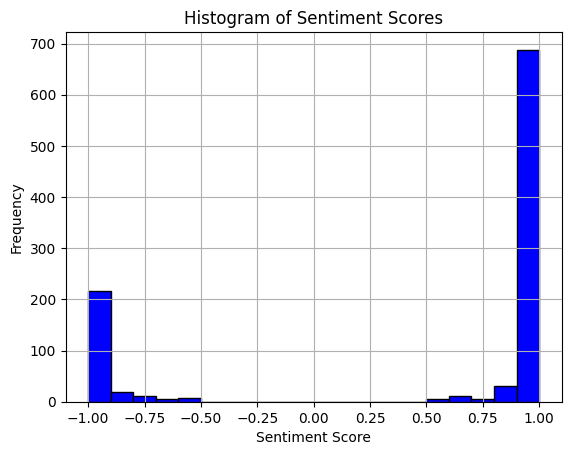

In [ ]:
import matplotlib.pyplot as plt
# Creating a histogram of the sentiment scores
plt.hist(result_df_head["sentiment_score"], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

As we can see from our sample data, most of the data that is extracted from the review text is either very close to 1 and -1, meaning very positive or negative, and there is a minority that is between 0.5-0.9 and -0.5 and -0.9.
The reason why there is no data between -0.5 and 0.5 is that the sentiment originally is values from 0.5-1 for either positive or negative, meaning, 0.4 of positive is equal to 0.6 negative, so the model is trained to decide either negative or positive. Since of this distribution of the data, we would like to perform discritization, so eventually there would be only 4 values for the sentiment: values that are positive above 0.9 would be classified as "loved", where below that would be "liked". for negative sentiment, we would define values above 0.9 as "hated", where below would be "disliked".

In [ ]:
average_sentiment = result_df_head.loc[(result_df_head['sentiment_score'] > 0.5) & (result_df_head['sentiment_score'] < 0.9)]
average_sentiment.head(20)

,overall,verified,reviewerID,asin,style,reviewText,summary,__index_level_0__,extracted_category,sentiment_result,sentiment_score,sentiment_label
7,3,False,A3MBENSVWGUFRK,0002005263,{'Format:': ' Mass Market Paperback'},This novel starts off with Navajo Tribal Polic...,A Solid Novel,134,unknown,"(0.8590920567512512, POSITIVE)",0.859092,POSITIVE
34,5,True,ACABSLRSDYYE5,0001720392,{'Format:': ' Hardcover'},I bought Dr. Suess when my kids were young and...,Delicious,2950,Children's Books,"(0.6194364428520203, POSITIVE)",0.619436,POSITIVE
35,5,False,A1PWJRR0T57SLB,0001720392,{'Format:': ' Hardcover'},The first time I took my brother to the main V...,Made me smile...,2963,Children's Books,"(0.6223681569099426, POSITIVE)",0.622368,POSITIVE
66,5,False,A1V09ASZ9HWQAE,0002051850,{'Format:': ' Paperback'},Controversy has swirled around Ernest Hemingwa...,The Book That Ripped the Pulitzer Apart,3861,Literature & Fiction,"(0.6365569233894348, POSITIVE)",0.636557,POSITIVE
162,4,False,A3QYDL5CDNYN66,0002005549,{'Format:': ' Mass Market Paperback'},"I liked this book, altho I felt he did too muc...",A little escapist thriller,9010,"Mystery, Thriller & Suspense","(0.8901907205581665, POSITIVE)",0.890191,POSITIVE
165,4,False,A2SLA0SXRQV8M0,0002005549,{'Format:': ' Mass Market Paperback'},A very good technological thriller and caution...,Very good techno-thriller by Crichton,9045,"Mystery, Thriller & Suspense","(0.6985737085342407, POSITIVE)",0.698574,POSITIVE
176,3,False,A3J0OXB9KIC5SS,0002005549,{'Format:': ' Hardcover'},If you don't have time to read Crichton's new ...,"""Andromeda Strain"" Revisited",9242,"Mystery, Thriller & Suspense","(0.8966445922851562, POSITIVE)",0.896645,POSITIVE
189,3,False,A23E9QQHJLNGUI,0002005549,{'Format:': ' Hardcover'},I have really enjoyed some of Mr. Crichton's b...,Not quite 3 stars!,9547,"Mystery, Thriller & Suspense","(0.895078718662262, POSITIVE)",0.895079,POSITIVE
197,5,False,A1VJU3NG5W15L4,0002005549,{'Format:': ' Hardcover'},"Prey is Crichton at his best.\nMeet Jack, out-...",The Andromeda Strain meets Jurassic Park,9734,"Mystery, Thriller & Suspense","(0.6218786239624023, POSITIVE)",0.621879,POSITIVE
245,4,False,A6Y5R84GTS368,0002226723,{'Format:': ' Paperback'},"In this ambitious novel, Gaskell superbly depi...",A changing England captured expertly,11849,Literature & Fiction,"(0.8211759328842163, POSITIVE)",0.821176,POSITIVE


In [ ]:
def get_sentiment_category(text):
    if pd.isna(text):
        return None

    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=510, truncation=True)

    truncated_text = tokenizer.decode(tokens)

    result = sentiment_analysis(truncated_text)[0]
    score = result['score']
    sentiment = result['label']

    if sentiment == "POSITIVE":
        if score > 0.9:
            category = 3 # "Loved"
        else:
            category = 2 # "Liked"
    elif sentiment == "NEGATIVE":
        if score > 0.9:
            category = 0 # "Hated"
        else:
          category = 1 # "Disliked"

    return category  # Return the category
result_df['sentiment_category'] = result_df["reviewText"].apply(get_sentiment_category)
result_df = result_df.drop(columns=["verified", "reviewText", "summary"])
result_df.to_parquet('/content/drive/MyDrive/books_to_kindle_and_books_parquets/booksכככ/books_1_with_sentiment.parquet')
result_df.head()


We kept the summary and review text for a long time, however, we can't extract really important data from the review text rather the sentiment, so it seems like the right time to drop them. In addition, we first thought that we would use the feature "verified: True/False" but this also seems meaningless, so we would drop that as well.

From here on we would use the sentiment in our model


In [ ]:
sentiment_path=f"/content/drive/MyDrive/books_to_kindle_and_books_parquets/books/combined_books_1_with_sentiment.parquet"

In [ ]:
result_df = pd.read_parquet(sentiment_path)

In [ ]:
result_df.head()

,overall,reviewerID,asin,style,__index_level_0__,extracted_category,sentiment_category
0,5,A3H9YD6K9TVKDP,0001713353,{'Format:': ' Hardcover'},15,Children's Books,0
1,5,A3QYDL5CDNYN66,0001061240,{'Format:': ' Hardcover'},47,Children's Books,3
2,5,A1BNWEJ7RVPLQ1,0001712799,{'Format:': ' Hardcover'},72,Children's Books,3
3,4,A3CKPNSGA7JOLK,0001712799,{'Format:': ' Hardcover'},98,Children's Books,3
4,5,A2MOBMVHECYVLE,0002006448,{'Format:': ' Hardcover'},106,Travel,3


In [ ]:
class SentimentModel(nn.Module):
    def __init__(self, n_users, n_books, n_categories, n_sentiments=4, n_factors=5, y_range=(0, 5.5)):
        super(SentimentModel, self).__init__()
        self.n_categories = n_categories
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.user_bias = nn.Embedding(n_users, 1)
        self.book_factors = nn.Embedding(n_books, n_factors)
        self.book_bias = nn.Embedding(n_books, 1)
        self.category_factors = nn.Embedding(n_categories, n_factors)
        self.sentiment_factors = nn.Embedding(n_sentiments, n_factors)
        self.y_range = y_range

    def forward(self, user_idx, book_idx, category_idx, sentiment_idx):
        user_embed = self.user_factors(user_idx)
        book_embed = self.book_factors(book_idx)
        category_embed = self.category_factors(category_idx)
        sentiment_embed = self.sentiment_factors(sentiment_idx)

        unknown_category_mask = category_idx == (self.n_categories - 1)
        category_embed = torch.where(unknown_category_mask.unsqueeze(1), torch.zeros_like(category_embed), category_embed)

        user_bias = self.user_bias(user_idx)
        book_bias = self.book_bias(book_idx)

        res = (user_embed * book_embed * category_embed * sentiment_embed).sum(dim=1, keepdim=True)
        res += user_bias + book_bias
        predicted_rating = torch.sigmoid(res)
        return predicted_rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]


In [ ]:
train_df, test_df = train_test_split(result_df, test_size=0.2)

# Create dictionaries to map user and book IDs to integers
user_to_idx = {user_id: i for i, user_id in enumerate(result_df['reviewerID'].unique())}
book_to_idx = {asin: i for i, asin in enumerate(result_df['asin'].unique())}
category_to_idx = {}
categories = result_df['extracted_category'].unique()
categories_series = pd.Series(categories)

# Drop "unknown" category
categories = categories_series[categories_series != "unknown"].to_numpy()

for i, category in enumerate(categories):
    category_to_idx[category] = i

# Add the special index for unknown categories
category_to_idx['unknown'] = i + 1

In [ ]:
train_df['user_idx'] = train_df['reviewerID'].map(user_to_idx)
train_df['book_idx'] = train_df['asin'].map(book_to_idx)
train_df['category_idx'] = train_df['extracted_category'].map(category_to_idx)
test_df['user_idx'] = test_df['reviewerID'].map(user_to_idx)
test_df['book_idx'] = test_df['asin'].map(book_to_idx)
test_df['category_idx'] = test_df['extracted_category'].map(category_to_idx)


In [ ]:
train_dataset = TensorDataset(
    torch.LongTensor(train_df['user_idx'].values),
    torch.LongTensor(train_df['book_idx'].values),
    torch.LongTensor(train_df['category_idx'].values),
    torch.LongTensor(train_df['sentiment_category'].values),
    torch.FloatTensor(train_df['overall'].values)
)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(
    torch.LongTensor(test_df['user_idx'].values),
    torch.LongTensor(test_df['book_idx'].values),
    torch.LongTensor(test_df['category_idx'].values),
    torch.LongTensor(test_df['sentiment_category'].values),
    torch.FloatTensor(test_df['overall'].values)
)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [ ]:
n_users = result_df['reviewerID'].nunique()
n_books = result_df['asin'].nunique()
n_categories = result_df['extracted_category'].nunique()
n_sentiments = 4

In [ ]:
model = SentimentModel(n_users,n_books,n_categories,n_sentiments).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for user_idx_batch, book_idx_batch, category_idx_batch, sentiment_idx_batch, ratings_batch in train_loader:
        optimizer.zero_grad()
        pred_ratings = model(user_idx_batch, book_idx_batch, category_idx_batch, sentiment_idx_batch).squeeze()
        loss = criterion(pred_ratings, ratings_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss}')

# Save model parameters
torch.save(model.state_dict(), '/content/drive/MyDrive/models/cf_with_sentiment.pth')


Epoch 1/20, Average Loss: 3.94796217918396
Epoch 2/20, Average Loss: 2.6270414924621583
Epoch 3/20, Average Loss: 2.275505120754242
Epoch 4/20, Average Loss: 2.177015006542206
Epoch 5/20, Average Loss: 2.1475828766822813
Epoch 6/20, Average Loss: 2.140223925113678
Epoch 7/20, Average Loss: 2.1375300121307372
Epoch 8/20, Average Loss: 2.135113401412964
Epoch 9/20, Average Loss: 2.13701429605484
Epoch 10/20, Average Loss: 2.1349894869327546
Epoch 11/20, Average Loss: 2.137885932922363
Epoch 12/20, Average Loss: 2.1357711291313173
Epoch 13/20, Average Loss: 2.13765629529953
Epoch 14/20, Average Loss: 2.1364680767059325
Epoch 15/20, Average Loss: 2.1360452342033387
Epoch 16/20, Average Loss: 2.1376677918434144
Epoch 17/20, Average Loss: 2.1367310285568237
Epoch 18/20, Average Loss: 2.137100167274475
Epoch 19/20, Average Loss: 2.1376393866539
Epoch 20/20, Average Loss: 2.138012716770172


In [ ]:
user_idx_tensor_test = torch.LongTensor(test_df['user_idx'].values).to(device)
book_idx_tensor_test = torch.LongTensor(test_df['book_idx'].values).to(device)
category_idx_tensor_test = torch.LongTensor(test_df['category_idx'].values).to(device)
sentiment_idx_tensor_test = torch.LongTensor(test_df['sentiment_category'].values).to(device)

model.eval()
with torch.no_grad():
    pred_ratings_test = model(user_idx_tensor_test, book_idx_tensor_test, category_idx_tensor_test, sentiment_idx_tensor_test).squeeze().cpu().numpy()

true_ratings = test_df['overall'].values
true_ratings, pred_ratings_test = true_ratings.reshape(-1), pred_ratings_test.reshape(-1)

ndcg = ndcg_score([true_ratings], [pred_ratings_test])
mae = mean_absolute_error(true_ratings, pred_ratings_test)
mrr = calculate_mrr(true_ratings, pred_ratings_test)
precision, recall, f1, _ = precision_recall_fscore_support(true_ratings, pred_ratings_test.round(), average='macro')
rmse = np.sqrt(mean_squared_error(true_ratings, pred_ratings_test))
map_score = calculate_map(true_ratings, pred_ratings_test)

print(f"Metrics:\nNDCG: {ndcg:.4f}\nMAE: {mae:.4f}\nMRR: {mrr:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-score: {f1:.4f}\nRMSE: {rmse:.4f}\nMAP: {map_score:.4f}")
save_performance_data('cf_with_sentiment', mae, rmse, precision, recall, f1, ndcg, mrr, map_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics:
NDCG: 0.9884
MAE: 1.2990
MRR: 0.0004
Precision: 0.0305
Recall: 0.2000
F1-score: 0.0530
RMSE: 1.4697
MAP: 0.2235


# Thoughts going forward

 We see that some models work better than others. Especially when adding bias. The next stpes will be comparing all of the models, choosting top 2 or top 3, then conducting error anaylisys and going forward we will choose only one to try and perfect it as much as possible.